In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# Read the data into a dataframe
df = pd.read_csv("cleaned_engagement_data.csv")

# Separate the features and target variable
X = df[
    [
        "total_direct_mentions",
        "total_indirect_mentions",
        "total_likes",
        "total_retweets",
        "total_project_followers",
        "total_indirect_followers",
        "soft_cap",
    ]
]
y = df["ico_success"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [2]:
X_train

,total_direct_mentions,total_indirect_mentions,total_likes,total_retweets,total_project_followers,total_indirect_followers,soft_cap
448,1600.0,22972,20927,10742,2801,603520,9800000.0
335,20900.0,143143,269584,232138,27785,5427931,110000.0
294,8370.0,90488,111816,90380,12105,2613058,500000.0
684,1320.0,7653,14547,19429,2068,156207,17540000.0
79,1290.0,11772,18325,12310,2512,174368,200000.0
...,...,...,...,...,...,...,...
71,6850.0,11298,100308,70442,7538,2127502,2480000.0
106,14000.0,195544,121878,168014,14617,6255127,14800000.0
270,1170.0,7303,7974,13793,1747,248832,1720000.0
435,21900.0,317392,312988,163780,30256,7739102,2400000.0


In [3]:
X_test

,total_direct_mentions,total_indirect_mentions,total_likes,total_retweets,total_project_followers,total_indirect_followers,soft_cap
196,577.0,5884,5848,5110,1126,280814,350000.0
299,7430.0,51847,92471,106743,7851,2567484,200000.0
744,343.0,4197,4710,2659,537,120299,14380000.0
227,3810.0,50737,40124,44982,5588,1638490,2400000.0
541,2530.0,11240,26216,35871,5057,1164264,20000000.0
...,...,...,...,...,...,...,...
442,2220.0,17613,2870,33044,3165,600087,20000000.0
760,5160.0,45335,74535,75333,8452,2099396,600000.0
714,1370.0,16194,7668,6965,2215,184729,30000000.0
666,17700.0,248127,121476,27234,23488,7241039,30000000.0


# Neural Network

To get started, we use a very simple classification problem and a very simple multi-layer perceptron architecture.

## Imports

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.datasets import make_classification
from torch import nn

from skorch import NeuralNetClassifier
from skorch.helper import SkorchDoctor

In [5]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)

In [6]:
plt.style.use("seaborn-v0_8")

## Load data

In [7]:
X, y = X_train.to_numpy().astype(np.float32), y_train.to_numpy().astype(np.int64)
X_test, y_test = X_test.to_numpy().astype(np.float32), y_test.to_numpy().astype(
    np.int64
)

In [8]:
X.shape, y.shape, y.mean()

((652, 7), (652,), 0.7285276073619632)

### Definition of the `PyTorch` classification `module`

This is just an MLP with two hidden layers.

In [9]:
class ClassifierModule(nn.Module):

    def __init__(
        self,
        num_features=7,
        num_units=1024,
        n_classes=2,
        nonlin=F.relu,
        dropout=0.1,
        depth=2,
        batchnorm=True,
    ):
        super(ClassifierModule, self).__init__()
        self.num_features = num_features
        self.num_units = num_units
        self.n_classes = n_classes
        self.nonlin = nonlin
        self.batchnorm = batchnorm
        self.depth = depth

        self.dense0 = nn.Linear(self.num_features, self.num_units)
        self.nonlin = self.nonlin
        self.dropout = nn.Dropout(dropout)

        layers = []
        for i in range(1, self.depth):
            layers.append(nn.Linear(self.num_units, self.num_units))
        self.dense1 = nn.Sequential(*layers)

        self.output = nn.Linear(self.num_units, self.n_classes)
        self.bn = nn.BatchNorm1d(self.n_classes)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = self.nonlin(self.dense1(X))
        X = self.output(X)

        if self.batchnorm:
            X = self.bn(X)

        X = F.softmax(X, dim=-1)
        return X

In [10]:
device = (
    torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)  # use gpu

device

device(type='cuda')

In [11]:
net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=50,
    lr=0.01,
    batch_size=32,
    device=device,

    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

In [13]:
%%time

from sklearn.model_selection import GridSearchCV
net = NeuralNetClassifier(
    ClassifierModule,
    lr=0.001,
    device=device,

    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0)

params = {
    'batch_size': [20, 40, 60],
    'max_epochs': [10, 20, 30, 40],
    "module__num_units": list(range(50, 101, 5)),
    "module__depth": list(range(2, 9)),
    "module__dropout": [i * 0.1 for i in range(6)],
}

gs = GridSearchCV(net, params, refit=False, cv=3, n_jobs=-1, verbose=1, scoring="accuracy")

grid_result = gs.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 5544 candidates, totalling 16632 fits
Best: 0.740773 using {'batch_size': 40, 'max_epochs': 20, 'module__depth': 2, 'module__dropout': 0.1, 'module__num_units': 95}
0.728512 (0.008022) with: {'batch_size': 20, 'max_epochs': 10, 'module__depth': 2, 'module__dropout': 0.0, 'module__num_units': 50}
0.725447 (0.008244) with: {'batch_size': 20, 'max_epochs': 10, 'module__depth': 2, 'module__dropout': 0.0, 'module__num_units': 55}
0.702413 (0.037228) with: {'batch_size': 20, 'max_epochs': 10, 'module__depth': 2, 'module__dropout': 0.0, 'module__num_units': 60}
0.725461 (0.001944) with: {'batch_size': 20, 'max_epochs': 10, 'module__depth': 2, 'module__dropout': 0.0, 'module__num_units': 65}
0.607344 (0.103816) with: {'batch_size': 20, 'max_epochs': 10, 'module__depth': 2, 'module__dropout': 0.0, 'module__num_units': 70}
0.705478 (0.025134) with: {'batch_size': 20, 'max_epochs': 10, 'module__depth': 2, 'module__dropout': 0.0, 'module__num_units': 75}
0.725468 (0.003

## Use skorch doctor

So far, everything we did was just as you would always proceed when working with PyTorch and skorch. Next step, however, is where `SkorchDoctor` enters the picture. We wrap the `net` inside the `SkorchDoctor` class. This wrapper class takes care of adding a bunch of hooks to the PyTorch module that enable us to collect important data.

In [14]:
best_params = {
    "batch_size": 40,
    "max_epochs": 20,
    "module__depth": 2,
    "module__dropout": 0.1,
    "module__num_units": 95,
}

In [15]:
best_net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=20,
    lr=0.001,
    batch_size=40,
    module__depth=2,
    module__num_units=95,
    module__dropout=0.0,
    device=device,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

In [16]:
doctor = SkorchDoctor(best_net)

### Train the doctor

The `SkorchDoctor` instance itself can be used like any ordinary estimator, i.e. you can fit it, call `predict` on it etc. For us to study the training process, we need to fit the instance with our training data. However, it is recommended to use only a very small amount of data, like 100 samples, and train for a small number of epochs, like 5 in this example:

In [17]:
doctor.fit(X[:650], y[:650])

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8947       0.6385        0.6568  0.1457
      2        0.8707       0.6231        0.6307  0.0420
      3        0.8833       0.6385        0.6195  0.0485
      4        0.8365       0.6308        0.6187  0.0440
      5        0.8840       0.6308        0.6179  0.0430
      6        0.8268       0.6308        0.6185  0.0472
      7        0.8021       0.6385        0.6174  0.0493
      8        0.8407       0.6615        0.6168  0.0492
      9        0.8601       0.6615        0.6153  0.0453
     10        0.8592       0.6308        0.6158  0.0481
     11        0.8304       0.6308        0.6169  0.0466
     12        0.8637       0.6308        0.6185  0.0400
     13        0.8286       0.6385        0.6104  0.0402
     14        0.8270       0.6308        0.6163  0.0421
     15        0.8338       0.6615        0.6113  0.0432
     16        0.8382       0.6

(0.6, 0.9)

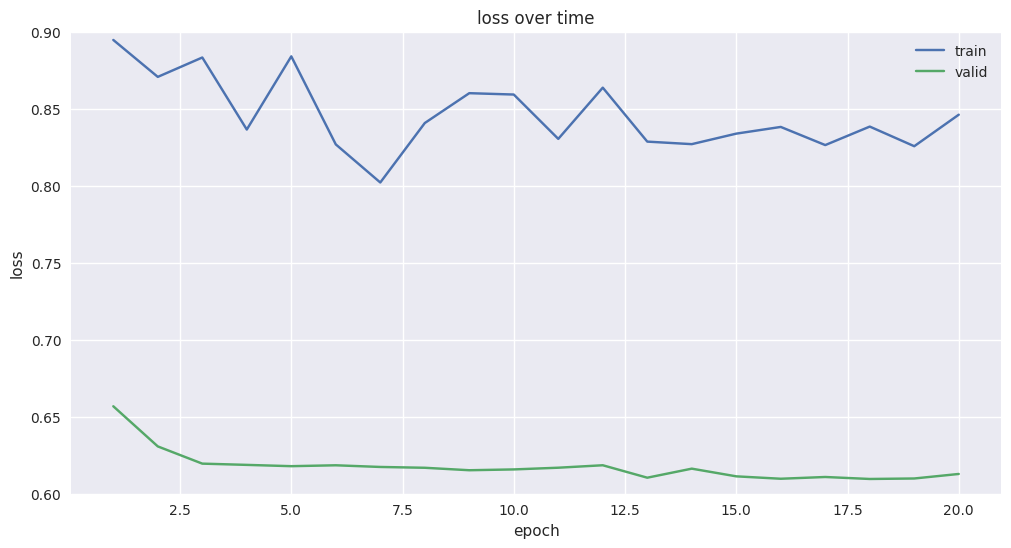

In [19]:
_, ax = plt.subplots(figsize=(12, 6))
doctor.plot_loss(ax=ax)
ax.set_ylim([0.6, 0.9])